# Réseaux de neurones

*http://exo7.emath.fr/cours/livre-deepmath.pdf* 

# 0. Chargement des modules et données

In [190]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn
import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D
from tensorflow.keras.optimizers import SGD
from tensorflow import keras

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
df = pd.read_csv('market_data_pd.csv',sep=',')

In [3]:
df = df[df.PD_1y>0.0]
df = df[df.PD_1y!=1.0]
df.head()

,Unnamed: 0,Reference Security,Bid Price,Ask Price,Mid Price,Cpn,Maturity,Common Eqty / Tot Assets,Debt/EBITDA,EBITDA,...,BCLASS Level 3,TCE Ratio,Interest Coverage Ratio,Risk-Based Cap Ratio,Lev Ratio to TCE,Tier-1 Ratio,Tot Debt / Tot Capital,PD_1y,reprice,Error %
0,0,BP432479 Corp,101.651,102.311,101.9810,4.25,05/19/2026,17.1580,1.61252,70.221,...,Consumer Cyclical,-171.027,0.857497,NaN,NaN,NaN,77.8533,0.064724,101.9810,7.378480e-11
1,1,BP432479 Corp,101.651,102.310,101.9805,4.25,05/19/2026,17.1580,1.61252,70.221,...,Consumer Cyclical,-171.027,0.857497,NaN,NaN,NaN,77.8533,0.064725,101.9805,0.000000e+00
2,2,BP432479 Corp,101.500,102.200,101.8500,4.25,05/19/2026,17.1580,1.61252,70.221,...,Consumer Cyclical,-171.027,0.857497,NaN,NaN,NaN,77.8533,0.065177,101.8500,8.371638e-14
3,3,EJ102177 Corp,102.240,102.660,102.4500,3.50,03/28/2022,19.2457,NaN,NaN,...,Basic Industry,NaN,NaN,NaN,NaN,NaN,80.4119,0.017218,102.4500,1.387101e-14
4,4,EJ102177 Corp,102.239,102.659,102.4490,3.50,03/28/2022,19.2457,NaN,NaN,...,Basic Industry,NaN,NaN,NaN,NaN,NaN,80.4119,0.017234,102.4490,0.000000e+00


In [10]:
#RENSEIGNER LES RATIOS FINANCIERS / VARIABLES CONSIDEREES 

df1 = df[["Common Eqty / Tot Assets",'Debt / Common Equity','Interest Coverage Ratio','Lev Ratio to TCE','Tier-1 Ratio','Tot Debt / Tot Capital','BCLASS Level 3',"TCE Ratio","PD_1y"]]


df1.replace(np.nan, 0.0,inplace=True)
#df1.dropna(inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [11]:
#df1 = df1.dropna(how = 'any') 
df1.head()

,Common Eqty / Tot Assets,Debt / Common Equity,Interest Coverage Ratio,Lev Ratio to TCE,Tier-1 Ratio,Tot Debt / Tot Capital,BCLASS Level 3,TCE Ratio,PD_1y
0,17.1580,351.535,0.857497,0.0,0.0,77.8533,Consumer Cyclical,-171.027,0.064724
1,17.1580,351.535,0.857497,0.0,0.0,77.8533,Consumer Cyclical,-171.027,0.064725
2,17.1580,351.535,0.857497,0.0,0.0,77.8533,Consumer Cyclical,-171.027,0.065177
3,19.2457,410.513,0.000000,0.0,0.0,80.4119,Basic Industry,0.000,0.017218
4,19.2457,410.513,0.000000,0.0,0.0,80.4119,Basic Industry,0.000,0.017234


In [12]:
df1.shape

(7429, 9)

# 1. Préparation des données

Nous commencerons par séparer les données non étiquietées des étiquettes, les étiquettes se trouvent dans l'array `y_full` et le reste des données dans `X_full`

In [13]:
X_full = np.array(df1.drop(columns=['PD_1y']))
y_full = np.array(df1['PD_1y'])

La prochaine étape consiste à séparer les features continues des features discrètes, cela sera utile car leurs traitements seront différent

In [14]:
features = list(df1.drop(columns=['PD_1y']).columns)

discrete_features = ['BCLASS Level {}'.format(i) for i in range(3,4)]
continuous_features = [s for s in features if not s in discrete_features]


continuous_features_idx = [features.index(feat_name) for feat_name in continuous_features]
discrete_features_idx = [features.index(feat_name) for feat_name in discrete_features]

## a. Statistiques descriptives

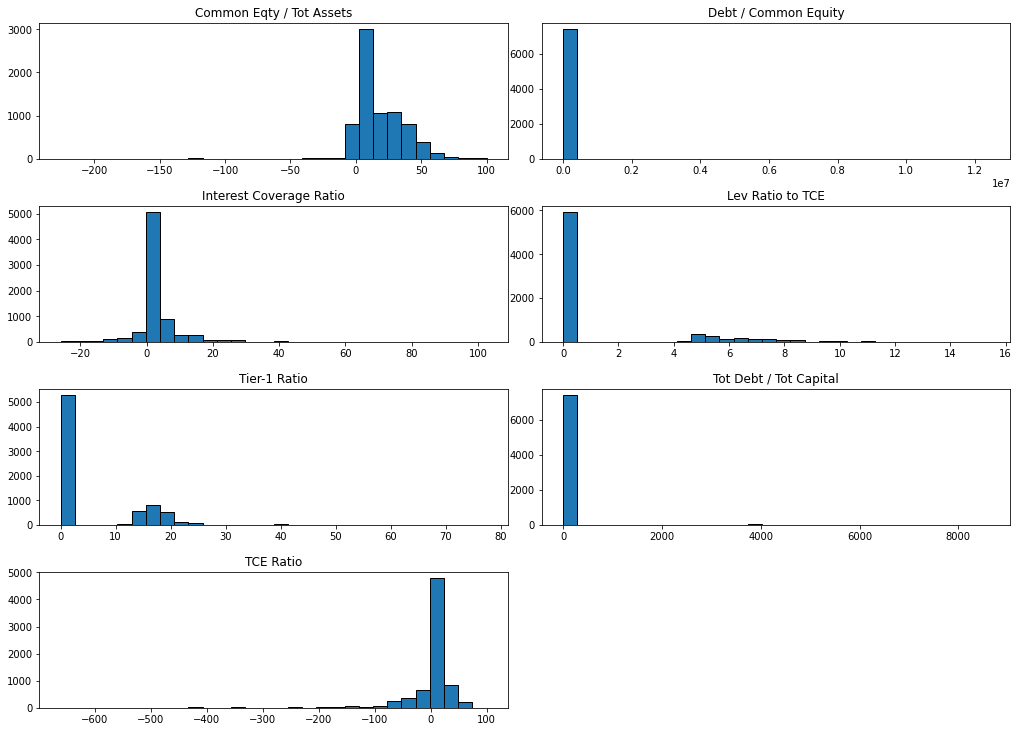

In [15]:
fig = plt.figure(figsize=(14,10))

# Histograms for continuous features
for (plot_idx, feat_idx) in enumerate(continuous_features_idx):
    # create a subplot in the (plot_idx+1) position of a 2x2 grid
    ax = fig.add_subplot(4, 2, (plot_idx+1))
    # plot the histogram of feat_idx
    h = ax.hist(X_full[:, feat_idx], bins=30, edgecolor='black')
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
# espacement entre les subplots
fig.tight_layout(pad=0.1)

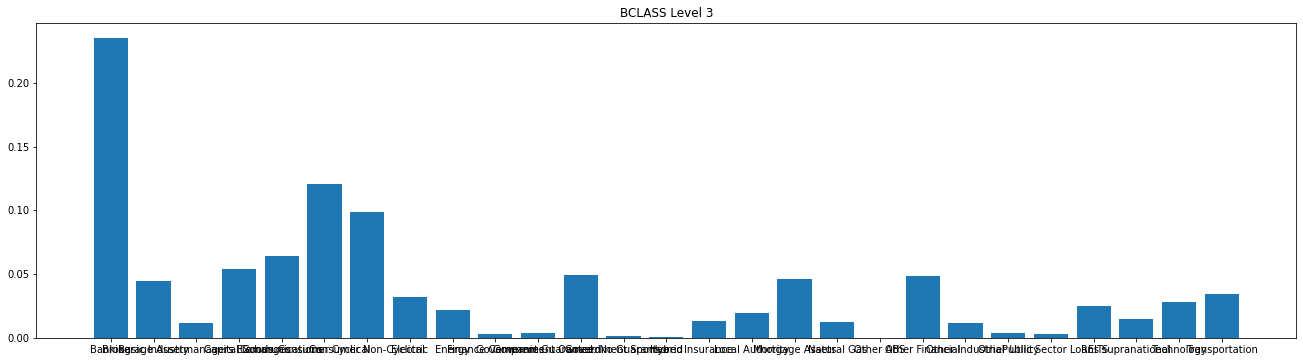

In [16]:
# Bar plots for discrete features
fig = plt.figure(figsize=(18, 14))

for (plot_idx, feat_idx) in enumerate(discrete_features_idx):
    # create a subplot in the (plot_idx+1) position of a 1x3 grid
    ax = fig.add_subplot(3, 1, (plot_idx+1))

    feature_values = np.unique(X_full[:, feat_idx])
    frequencies = [(float(len(np.where(X_full[:, feat_idx]==value)[0]))/X_full.shape[0]) \
                   for value in feature_values]
    
    b = ax.bar(range(len(feature_values)), frequencies, width=0.8, 
               tick_label=list([n for n in feature_values]))
    
    
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
fig.tight_layout(pad=0.35)

## b. Traitement des données

In [17]:
## A FAIRE COMME CELA :
"""
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train_submit)

X_train_submit = enc.transform(X_train_submit)
X_test_submit = enc.transform(X_test_submit)

"""



class Pipeline:
    def __init__(self, X_train):
        """
        Se fit sur le jeu de TRAIN, une seule fois
        """
        self.ohe = preprocessing.OneHotEncoder(categories='auto',sparse=False).fit(X_train[:,discrete_features_idx])
        self.std_scaler = preprocessing.StandardScaler().fit(X_train[:,continuous_features_idx])
        print(self.ohe.categories_)
        
    def traitement(self,X):
        """
        Permet de traiter n'importe quel vecteur X ensuite
        """
    
        X_continuous_scaled = self.std_scaler.transform(X[:,continuous_features_idx])
        X_discrete_encoded = self.ohe.transform(X[:,discrete_features_idx])
        print('moyenne = {}'.format(np.mean(X_continuous_scaled)))
        
        X_processed = np.hstack((X_discrete_encoded, X_continuous_scaled))
    
        return X_processed

In [18]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_full, y_full, test_size=0.10,
                                                                    #stratify=y_full, # stratification
                                                                    random_state=92)

pipe = Pipeline(X_train)
X_train = pipe.traitement(X_train)
X_test  = pipe.traitement(X_test)

[array(['Banking', 'Basic Industry', 'Brokerage Assetmanagers Exchanges',
       'Capital Goods', 'Communications', 'Consumer Cyclical',
       'Consumer Non-Cyclical', 'Electric', 'Energy', 'Finance Companies',
       'Government Guaranteed', 'Government Owned. No Guarantee',
       'Government Sponsored', 'Hybrid', 'Insurance', 'Local Authority',
       'Mortgage Assets', 'Natural Gas', 'Other ABS', 'Other Financial',
       'Other Industrial', 'Other Utility', 'Public Sector Loans',
       'REITs', 'Supranational', 'Technology', 'Transportation'],
      dtype=object)]
moyenne = -1.7762809299587992e-17
moyenne = 0.01133054475227209


## b. Traitement des données

### Première version de traitement des données (beug sur subtilité bases de train/test)

### Version corrigée (à rechercker)

Séparation en base de test / train. Besoin de distinguer les cas selon le type de variables : 

$-$ variables quali : les binariser avant de séparer en test et train afin d'avoir des colonnes pour toutes les modalités existantes dans le dataset. 

$-$ variable quanti : il faut les standariser en fonction de la base de train, càd : on entraîne la standardisation QUE sur la base de train, puis on applique les coefficients à la base de test également. Important, **sinon notre base de train dépend de la base de test**.

*Transformation des qualis*

# II. Réseaux de neurones : prédiction de la PD

## a. Implémentation du modèle

In [22]:
X_train.shape
#RESEAUX DE NEURONES 
#http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Packages_Python_for_Deep_Learning.pdf

#Explications très bien dans ce document : 

#http://exo7.emath.fr/cours/livre-deepmath.pdf 

#très bon document (parties Python, keras avec les codes et explications)

(6686, 34)

In [37]:
model = Sequential()
model.add(Dense(units=12,input_dim=34,))#activation="sigmoid")) #6 is good
model.add(Dense(units=6))
model.add(Dense(units=1,activation="sigmoid"))
#modele.add(Dropout(0.3))
learning_rate = 0.15

sgd = SGD(learning_rate)

#dim première couche = nombre de variables du df 

**Fonction sigmoïde :** continue et à valeurs dans [0,1] (comme les probabilités de défaut). Régression logit. 

In [38]:
#modele.compile(loss='mean_squared_error',optimizer=sgd,metrics=[tf.keras.metrics.MeanSquaredError()])
#optimizer = sgd
model.compile(loss='mean_squared_error',optimizer='adam',metrics=[tf.keras.metrics.MeanSquaredError()])

In [39]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 12)                420       
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/20
50/50 [==============================] - 0s 4ms/step - loss: 0.1598 - mean_squared_error: 0.1598 - val_loss: 0.1098 - val_mean_squared_error: 0.1098
Epoch 2/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0695 - mean_squared_error: 0.0695 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 3/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0333 - mean_squared_error: 0.0333 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 4/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 5/20
50/50 [==============================] - 0s 2ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 6/20
50/50 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 7/20
50/50 [======================

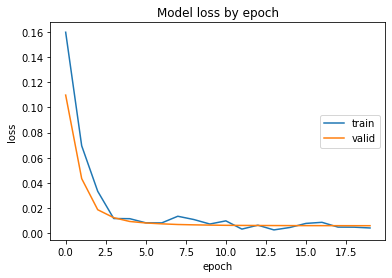

In [40]:
history = model.fit(X_train, y_train,         # Train the model using the training set...
          batch_size=10, epochs=20,
          verbose=1, validation_split=0.4,steps_per_epoch=50)           # ...holding out 40% of the data for validation

# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

    
import matplotlib.pyplot as plt

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In [41]:
#Résultats 

resultat = model.evaluate(X_test, y_test, verbose=1)
print("Valeur de l'erreur sur les données de test (loss):", resultat[0])
print('Précision sur les données de test (MSE):', resultat[1])

24/24 [==============================] - 0s 443us/step - loss: 0.0062 - mean_squared_error: 0.0062
Valeur de l'erreur sur les données de test (loss): 0.006241211201995611
Précision sur les données de test (MSE): 0.006241211201995611


## b. Observation des résultats 

In [42]:
def ecart_relatif(row) : 
    théo = row['Théorique']
    préd = row['Prédiction']
    return abs(théo - préd) / théo

In [43]:
prediction = pd.DataFrame(data= model.predict(X_test) ,columns=['Prédiction'])
théorique = pd.DataFrame(data= y_test ,columns=['Théorique'])
prediction, théorique = prediction.reset_index() , théorique.reset_index()

results = pd.merge(théorique, prediction, on = 'index').drop(columns=['index'])
results["Ecart_relatif"] = results.apply(ecart_relatif,axis=1)

In [44]:
results.replace(np.inf, 0.0,inplace=True)

In [45]:
results

,Théorique,Prédiction,Ecart_relatif
0,0.010892,0.005357,0.508181
1,0.004058,0.018729,3.615545
2,0.001204,0.019399,15.105993
3,0.003668,0.017050,3.648268
4,0.010138,0.035994,2.550287
...,...,...,...
738,0.010408,0.011237,0.079627
739,0.088065,0.008917,0.898744
740,0.005997,0.037715,5.288920
741,0.002626,0.009797,2.730924


In [46]:
print("L'écart relatif moyen est de " + str(results["Ecart_relatif"].mean() * 100) + "%")

L'écart relatif moyen est de 751.1346701547312%


In [47]:
results.sort_values('Ecart_relatif',inplace=True)

In [48]:
#results

(-0.01, 0.1)

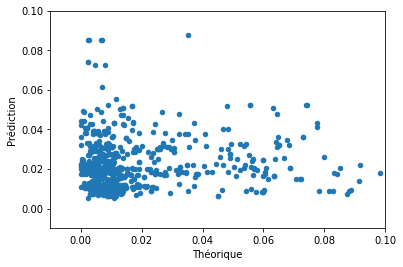

In [49]:
results.plot.scatter("Théorique","Prédiction")
plt.xlim(-.01,.1)
plt.ylim(-.01,.1)

---------------

# III. Réseaux de neurones : Test classification multi-classe

In [148]:
df = pd.read_csv('market_data_pd.csv',sep=',')
df = df[["Common Eqty / Tot Assets",'Debt / Common Equity','BCLASS Level 3',"PD_1y","TCE Ratio"]]
df = df[df.PD_1y>0.0]
df = df[df.PD_1y!=1.0]
df = df[df.PD_1y<0.05]

#df['PD_1y'] = pd.read_csv('PD_1y.csv')['PD_1y']
df.replace(np.nan, 0.0,inplace=True)

## a. Classification des PD

**Première version de traitement des données (beug sur subtilité bases de train/test)**

In [149]:
#ATTENTION : CHANGEMENT A FAIRE 
#il faut paramétrer les algorithmes de classification seulement en utilisant la base de train. 
#et ensuite seulement, appliquer la classification sur la base de test 

#sinon, tu utilises une base normalement inconnue (la base de test) pour paramétrer ton algo. 
#(même si le changement est pas ouf, il faut inverser l'ordre dans lequel on fait ça)

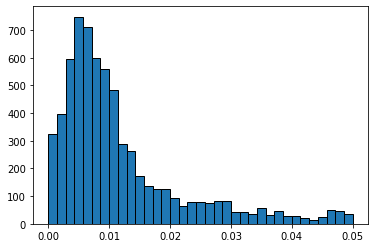

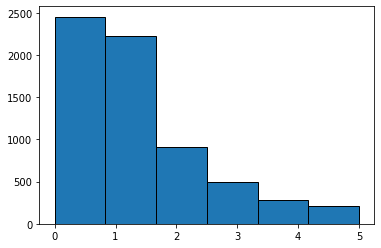

In [150]:
from numpy.random import randn
from sklearn.preprocessing import KBinsDiscretizer

data = np.array(df['PD_1y'])
# histogram of the raw data
plt.hist(data, bins=35,edgecolor='black')
plt.show()
# reshape data to have rows and columns
data = data.reshape((len(data),1))
# discretization transform the raw data
kbins = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='kmeans')
data_trans = kbins.fit_transform(data)

# summarize first few rows
#print(data_trans[:10, :])
# histogram of the transformed data
plt.hist(data_trans, bins=6,edgecolor='black' )
plt.show()

In [51]:
df['PD_1y'] = data_trans

In [141]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_full, y_full, test_size=0.10,
                                                                    #stratify=y_full, # stratification
                                                                    random_state=92)
pipe = Pipeline(X_train)
X_train = pipe.traitement(X_train)
X_test  = pipe.traitement(X_test)

[array(['Banking', 'Basic Industry', 'Brokerage Assetmanagers Exchanges',
       'Capital Goods', 'Communications', 'Consumer Cyclical',
       'Consumer Non-Cyclical', 'Electric', 'Energy', 'Finance Companies',
       'Government Guaranteed', 'Government Owned. No Guarantee',
       'Government Sponsored', 'Hybrid', 'Insurance', 'Local Authority',
       'Mortgage Assets', 'Natural Gas', 'Other ABS', 'Other Financial',
       'Other Industrial', 'Other Utility', 'Public Sector Loans',
       'REITs', 'Supranational', 'Technology', 'Transportation'],
      dtype=object)]
moyenne = -1.7762809299587992e-17
moyenne = 0.01133054475227209


**Version corrigée (à rechercker)**

In [270]:
#Au départ : reprendre base de train et de test créées dans la partie I. 
#X_train, y_train, X_test, y_test

class Discretizer:
    def __init__(self, y_train, nb_class=6):
        
        self.nb_class = nb_class
        self.y_train = y_train.reshape((-1,1))

        self.kbins = KBinsDiscretizer(n_bins=self.nb_class, encode='ordinal', strategy='quantile')#strategy : uniform, quantile, kmeans
        self.kbins.fit(self.y_train)
        
        
    def discretize(self,y):
        y = y.reshape((-1,1))
        y_class = self.kbins.transform(y)
        return y_class

In [271]:
nb_class = 10
discretizer = Discretizer(y_train, nb_class=nb_class)

y_train_class = discretizer.discretize(y_train)
y_test_class  = discretizer.discretize(y_test)

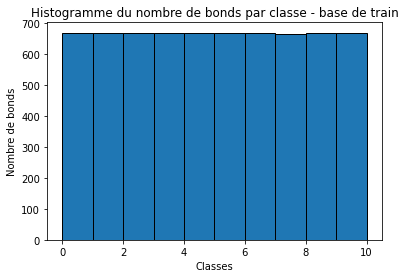

In [272]:
plt.hist(y_train_class, range = (0, nb_class), bins = nb_class, edgecolor='black' )
plt.xlabel('Classes')
plt.ylabel('Nombre de bonds')
plt.title('Histogramme du nombre de bonds par classe - base de train')
plt.show()

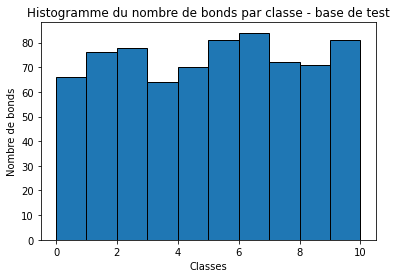

In [273]:
plt.hist(y_test_class, range = (0, nb_class), bins = nb_class, edgecolor='black' )
plt.xlabel('Classes')
plt.ylabel('Nombre de bonds')
plt.title('Histogramme du nombre de bonds par classe - base de test')
plt.show()

## b. Implémentation du modèle

In [298]:
model = Sequential()
model.add(Dense(units=12,input_dim=34)) #6 is good
model.add(Dense(units=12))
model.add(Dropout(0.3))
model.add(Dense(units=10,activation="softmax")) #output

#model.add(Conv1D(
#32, 3, activation='relu', input_shape=input_shape[2:])(x)


In [299]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [300]:
#model.fit(X_train,y_train,validation_split=0.4, epochs=40)

In [301]:
history = model.fit(X_train, y_train_class,         # Train the model using the training set...
          batch_size=20, epochs=80,
          verbose=1, validation_split=0.4,steps_per_epoch=80)  

Epoch 1/80
80/80 [==============================] - 0s 2ms/step - loss: 2.3912 - sparse_categorical_accuracy: 0.1069 - val_loss: 2.3079 - val_sparse_categorical_accuracy: 0.1170
Epoch 2/80
80/80 [==============================] - 0s 1ms/step - loss: 2.3300 - sparse_categorical_accuracy: 0.1125 - val_loss: 2.2673 - val_sparse_categorical_accuracy: 0.1555
Epoch 3/80
80/80 [==============================] - 0s 1ms/step - loss: 2.2828 - sparse_categorical_accuracy: 0.1326 - val_loss: 2.2433 - val_sparse_categorical_accuracy: 0.1772
Epoch 4/80
80/80 [==============================] - 0s 1ms/step - loss: 2.2797 - sparse_categorical_accuracy: 0.1419 - val_loss: 2.2290 - val_sparse_categorical_accuracy: 0.1929
Epoch 5/80
80/80 [==============================] - 0s 1ms/step - loss: 2.2373 - sparse_categorical_accuracy: 0.1825 - val_loss: 2.2105 - val_sparse_categorical_accuracy: 0.2101
Epoch 6/80
80/80 [==============================] - 0s 1ms/step - loss: 2.2297 - sparse_categorical_accuracy: 

Epoch 47/80
80/80 [==============================] - 0s 1ms/step - loss: 2.0682 - sparse_categorical_accuracy: 0.2494 - val_loss: 2.0834 - val_sparse_categorical_accuracy: 0.2501
Epoch 48/80
80/80 [==============================] - 0s 1ms/step - loss: 2.0585 - sparse_categorical_accuracy: 0.2558 - val_loss: 2.0818 - val_sparse_categorical_accuracy: 0.2497
Epoch 49/80
80/80 [==============================] - 0s 2ms/step - loss: 2.0860 - sparse_categorical_accuracy: 0.2469 - val_loss: 2.0783 - val_sparse_categorical_accuracy: 0.2531
Epoch 50/80
80/80 [==============================] - 0s 1ms/step - loss: 2.0619 - sparse_categorical_accuracy: 0.2531 - val_loss: 2.0802 - val_sparse_categorical_accuracy: 0.2516
Epoch 51/80
80/80 [==============================] - 0s 3ms/step - loss: 2.0700 - sparse_categorical_accuracy: 0.2546 - val_loss: 2.0814 - val_sparse_categorical_accuracy: 0.2579
Epoch 52/80
80/80 [==============================] - 0s 1ms/step - loss: 2.1151 - sparse_categorical_accu

24/24 [==============================] - 0s 515us/step - loss: 2.0625 - sparse_categorical_accuracy: 0.2759
The final loss on the TEST set is: 2.06.
The final sparse_categorical_accuracy on the TEST set is: 0.28.


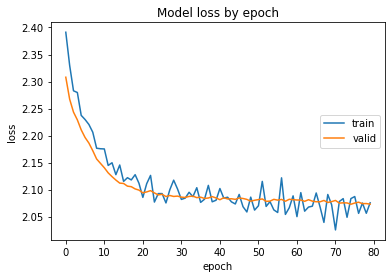

In [302]:
# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, y_test_class, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In [303]:
y=model.predict(X_test)

In [304]:
y_predicted = [np.argmax(pred) for pred in y]

In [305]:
for i in range(len(y_predicted)):
    print("predicted: ", y_predicted[i], "| Actual Label: ",y_test_class[i][0], " True" if (y_predicted[i]==y_test_class[i][0]) else " False")
print("\n")
print(np.sum(y_predicted==y_test_class[:,0]),'/',len(y_predicted))

predicted:  1 | Actual Label:  5.0  False
predicted:  3 | Actual Label:  1.0  False
predicted:  0 | Actual Label:  0.0  True
predicted:  9 | Actual Label:  1.0  False
predicted:  9 | Actual Label:  5.0  False
predicted:  8 | Actual Label:  1.0  False
predicted:  1 | Actual Label:  6.0  False
predicted:  9 | Actual Label:  4.0  False
predicted:  5 | Actual Label:  2.0  False
predicted:  0 | Actual Label:  0.0  True
predicted:  7 | Actual Label:  7.0  True
predicted:  7 | Actual Label:  5.0  False
predicted:  1 | Actual Label:  4.0  False
predicted:  1 | Actual Label:  3.0  False
predicted:  8 | Actual Label:  9.0  False
predicted:  2 | Actual Label:  8.0  False
predicted:  9 | Actual Label:  0.0  False
predicted:  1 | Actual Label:  2.0  False
predicted:  5 | Actual Label:  2.0  False
predicted:  7 | Actual Label:  1.0  False
predicted:  4 | Actual Label:  4.0  True
predicted:  9 | Actual Label:  9.0  True
predicted:  9 | Actual Label:  4.0  False
predicted:  5 | Actual Label:  7.0  Fal

predicted:  5 | Actual Label:  5.0  True
predicted:  3 | Actual Label:  0.0  False
predicted:  9 | Actual Label:  7.0  False
predicted:  0 | Actual Label:  1.0  False
predicted:  7 | Actual Label:  2.0  False
predicted:  5 | Actual Label:  4.0  False
predicted:  1 | Actual Label:  1.0  True
predicted:  9 | Actual Label:  7.0  False
predicted:  9 | Actual Label:  8.0  False
predicted:  4 | Actual Label:  2.0  False
predicted:  6 | Actual Label:  6.0  True
predicted:  9 | Actual Label:  3.0  False
predicted:  7 | Actual Label:  4.0  False
predicted:  4 | Actual Label:  2.0  False
predicted:  1 | Actual Label:  2.0  False
predicted:  4 | Actual Label:  6.0  False
predicted:  7 | Actual Label:  3.0  False
predicted:  3 | Actual Label:  3.0  True
predicted:  5 | Actual Label:  6.0  False
predicted:  3 | Actual Label:  3.0  True
predicted:  1 | Actual Label:  0.0  False
predicted:  0 | Actual Label:  0.0  True
predicted:  6 | Actual Label:  8.0  False
predicted:  2 | Actual Label:  6.0  Fals

predicted:  1 | Actual Label:  1.0  True
predicted:  1 | Actual Label:  5.0  False
predicted:  9 | Actual Label:  6.0  False
predicted:  6 | Actual Label:  8.0  False
predicted:  5 | Actual Label:  8.0  False
predicted:  4 | Actual Label:  9.0  False
predicted:  7 | Actual Label:  7.0  True
predicted:  4 | Actual Label:  8.0  False
predicted:  6 | Actual Label:  2.0  False
predicted:  9 | Actual Label:  0.0  False
predicted:  3 | Actual Label:  3.0  True
predicted:  9 | Actual Label:  0.0  False
predicted:  3 | Actual Label:  4.0  False
predicted:  0 | Actual Label:  0.0  True
predicted:  7 | Actual Label:  7.0  True
predicted:  1 | Actual Label:  1.0  True
predicted:  1 | Actual Label:  0.0  False
predicted:  7 | Actual Label:  4.0  False
predicted:  4 | Actual Label:  5.0  False
predicted:  9 | Actual Label:  8.0  False
predicted:  9 | Actual Label:  7.0  False
predicted:  9 | Actual Label:  1.0  False
predicted:  5 | Actual Label:  7.0  False
predicted:  9 | Actual Label:  9.0  True

In [306]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [307]:
CM = confusion_matrix(y_test_class[:,0], y_predicted)

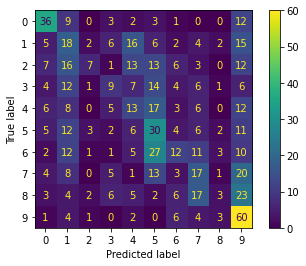

In [308]:
ConfusionMatrixDisplay(CM).plot()